# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

In [12]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os

import lab02_functions as imPro
from lab02_functions import PlotData
import skimage
import skimage.transform
from numpy.fft import fft

importlib.reload(imPro);

# Part 1
Dataset source: MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Our goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.

(for arthur, here is what to do)
Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

## 1.1 Data visualization

In [2]:
zeros=imPro.get_zeros()
ones = imPro.get_ones()

## 1.2 Fourier descriptors

### The theory

Fourier Descriptors (FD) is a method that can be used to encode contours and that offers a comparison tool between different contours. 
The main idea is to get the most Fourier Series of the complex path, and then to extract the main harmonics. 
By only keeping the most important harmonics, it is possible to reconstruct a contour with almost all the variance of the initial contour.

Assume you have a contour $x_i, y_i$ for $i = 1,...,N$ different points. Construct the complex path $u_k = x_k + j \cdot y_k$. 
Let's denote by $f_j$ the j-iest element of the Fourier Serie, then the FD are all the $f_j$ fourier's harmonic. 

### Example of FD reconstruction 

<Figure size 432x288 with 0 Axes>

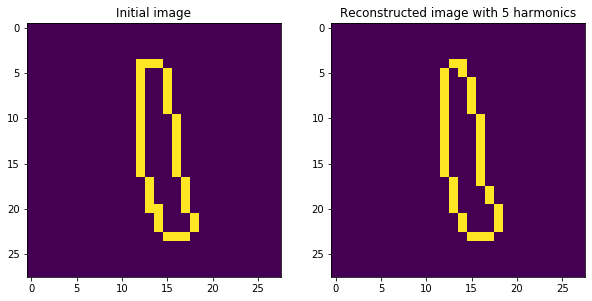

In [3]:
img = ones[1]
[X,Y] = imPro.get_outmost_contour(img)
im_contour = imPro.get_contour_image([X,Y])
signal = X + 1j * Y
fourier = np.fft.fft(signal)

k = 5 # number of harmonic to use
fourier[k:-k] = 0
fourier_inv = np.fft.ifft(fourier)
X_hat = np.rint(fourier_inv.real).astype(int)
Y_hat = np.rint(fourier_inv.imag).astype(int)
im_contour_hat = imPro.get_contour_image([X_hat, Y_hat])

plt.figure()
fig, axs = plt.subplots(1,2,figsize = (10,5))
axs[0].imshow(im_contour)
axs[0].set_title('Initial image')
axs[1].imshow(im_contour_hat)
axs[1].set_title('Reconstructed image with {} harmonics'.format(k));

We can see that the reconstruction is very good. This illustration shows us how to use the Fourier Descriptor for reconstruction, but eventually this is not what we want to do. We want to be able to classify using the Fourier Descriptors of one path. 

## Classification with Fourier Descriptors

We are interested in **classifying shapes** using Fourier Descriptors. How can this be performed ? Fourier Descriptor are a way to encapsulate the most meaningful data about each curve, so to perform classification one needs to select some **features** that best describe this 'variance' among the data. Once we have meaningful features, we can simply plot them for different images and see wether yes or not classification could be performed. 

### First tentative: using unormalized Fourier Descriptors

The first thing that one can try is to take the values of the **N-highest amplitudes** of the FDs for each contour and then plot it. In this case the *feature vector* is $x_{feature} = x = [A_1, A_2]$ or $x = [A_1, A_3]$

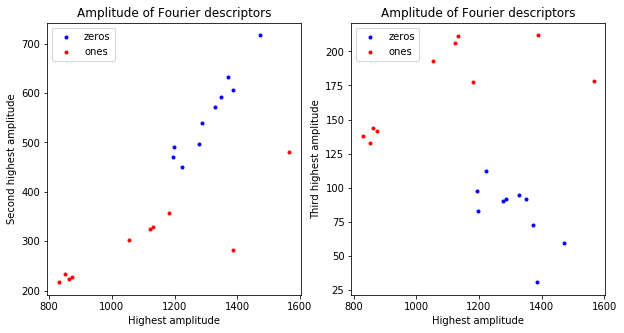

In [4]:
amplitudes_zeros, amplitudes_ones = [],[]
for img in zeros:
    [X,Y] = imPro.get_outmost_contour(img)    
    signal = X + 1j * Y
    fourier = np.fft.fft(signal)
    amplitudes = imPro.get_amplitude_first_descriptors(fourier, n_descriptor = 4)
    amplitudes_zeros.append(amplitudes)

for img in ones:
    [X,Y] = imPro.get_outmost_contour(img)
    signal = X + 1j * Y
    fourier = np.fft.fft(signal)
    amplitudes = imPro.get_amplitude_first_descriptors(fourier, n_descriptor = 4)
    amplitudes_ones.append(amplitudes)

amplitudes_zeros, amplitudes_ones = np.array(amplitudes_zeros), np.array(amplitudes_ones)

fig, axs = plt.subplots(1,2, figsize = (10,5))

axs[0].plot(amplitudes_zeros[:,0], amplitudes_zeros[:,1],'.b', label = 'zeros')
axs[0].plot(amplitudes_ones[:,0], amplitudes_ones[:,1],'.r', label = 'ones')
axs[0].set_xlabel('Highest amplitude')
axs[0].set_ylabel('Second highest amplitude')
axs[0].set_title('Amplitude of Fourier descriptors')
axs[0].legend();

axs[1].plot(amplitudes_zeros[:,0], amplitudes_zeros[:,2],'.b', label = 'zeros')
axs[1].plot(amplitudes_ones[:,0], amplitudes_ones[:,2],'.r', label = 'ones')
axs[1].set_xlabel('Highest amplitude')
axs[1].set_ylabel('Third highest amplitude')
axs[1].set_title('Amplitude of Fourier descriptors')
axs[1].legend();

We see using that already with this method  the contours are quite separable. 

### Second tentative: using Fourier Descriptors Normalisation

There are four transformations that can influence Fourier Transforms: *rotation, scaling, translation and the selection of the starting point*. What we want to do is to make a robust method that doesn't depend on any of those transformations. Each different case needs to be traited separatly. 

#### Effect of each transformation

1. **Scalling**: After scalling, $f_l$ becomes $f_l'=s\cdot f_l$. 

2. **Translation**: After a translation by an offset $z_0$, $f_l$ becomes $f_l'=f_l + z_0 \cdot \delta(l)$, i.e. it affects only the DC component of the FDs. 

3. **Selection of starting points**: After selecting $k_0$ as initial point, $f_l$ becomes $f_l'=f_l \cdot e^{-j\cdot\frac{2\pi k_0}{N}l}$. 

4. **Rotation**: After a rotation of $\theta$, $f_l$ becomes $f_l'=f_l \cdot e^{j\theta}$ which is an offset of all the phases by a constant value. 

The following block illustrates the effect of rotation and of scalling (just as a 'proof' of concept) and we see that indeed the theory is respected when applying transformations. 

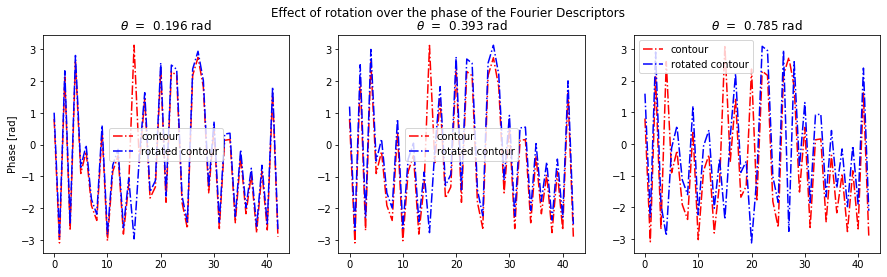

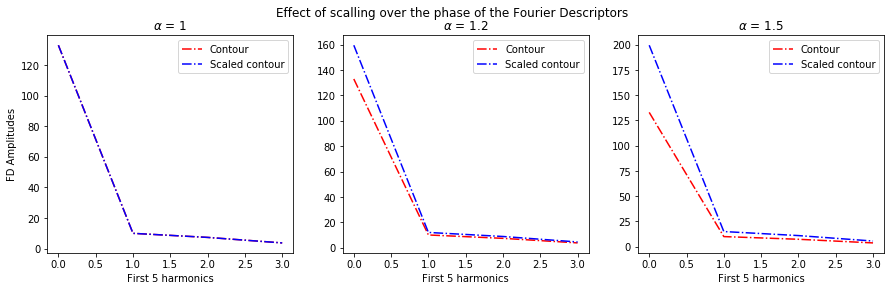

In [5]:
# %% Rotation effect (the modulus is constant)
fig, axs = plt.subplots(1,3,figsize = (15,4))
img = ones[1]
imPro.plot_FD_rotation_invariance(img, np.pi/16, axs[0])
imPro.plot_FD_rotation_invariance(img, np.pi/8, axs[1])
imPro.plot_FD_rotation_invariance(img, np.pi/4, axs[2])
axs[0].set_ylabel('Phase [rad]')
fig.suptitle("Effect of rotation over the phase of the Fourier Descriptors");

# %% Scalling effect (the phase is constant)
fig, axs = plt.subplots(1,3,figsize = (15,4))
img = ones[1]
imPro.plot_FD_scaling_invariance(img, 1, axs[0])
imPro.plot_FD_scaling_invariance(img, 1.2, axs[1])
imPro.plot_FD_scaling_invariance(img, 1.5, axs[2])
axs[0].set_ylabel('FD Amplitudes')
fig.suptitle("Effect of scalling over the phase of the Fourier Descriptors");

#### Normalisation of each transformation

Here is what we can do to make our FD robust to all transformation
1. **Scalling**: take the norm of the first FD $r_1 = |f_1|$ and devide every FDs by $r_1$.
2. **Translation**: set the initial FD $f_0$ at zero.
3. **Starting-point**: multiply every FD by a phase shift of $e^{-j\phi_1 k}$ where $\phi_1$ is the phase of the first FD.
4. **Rotation**: set the phase of the FD with highest amplitude at zero, and then shift all the other phase accordingly

One can **assess** the normalisation with the following block of code, where the first part define the transformation to be applied.

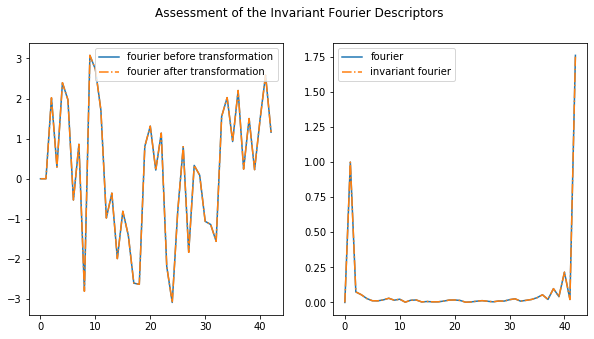

In [6]:
### Transformation parameters
# 1. rotation
theta = np.pi/4 * 0 
R_rot = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
# 2. scalling
a = 1.3
R_sca = np.array([[a,0],[0,a]])
# 3. translation 
tx = 2
ty = 0
# 4. Starting point 
k_0 = 1

### Construct the fourier descriptors
img = ones[1]
X1, Y1 = imPro.get_outmost_contour(img)
contour1 = np.column_stack([X1, Y1])
R = R_sca @ R_rot
contour2 = contour1 @ R
contour2 = contour2 + tx + 1j*ty
X2, Y2 = contour2[:, 0], contour2[:, 1]
if k_0 > 0:
    X2 = np.concatenate((X2[k_0:],X2[0:k_0]))
    Y2 = np.concatenate((Y2[k_0:],Y2[0:k_0]))
    
signal1 = X1 + 1j * Y1
fourier1 = np.fft.fft(signal1)
signal2 = X2 + 1j * Y2
fourier2 = np.fft.fft(signal2)

### Make fourier Invariant
fourier1_n = imPro.translation_invariance(fourier1)
fourier2_n = imPro.translation_invariance(fourier2)
fourier1_n = imPro.scaling_invariance(fourier1)
fourier2_n = imPro.scaling_invariance(fourier2)
fourier1_n = imPro.starting_point_invariance(fourier1_n)
fourier2_n = imPro.starting_point_invariance(fourier2_n)

# Plotting all this 
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(np.angle(fourier1_n), label = 'fourier before transformation')
axs[0].plot(np.angle(fourier2_n),'-.', label = 'fourier after transformation')
axs[1].plot(np.abs(fourier1_n), label = 'fourier')
axs[1].plot(np.abs(fourier2_n),'-.', label = 'invariant fourier')
axs[0].legend();
axs[1].legend();
fig.suptitle('Assessment of the Invariant Fourier Descriptors');

#### Feature vector with normalised Fourier Descriptors

Now that we have robust fourier descriptors that have been assessed, in order to have a good classification we must use a good feature vector $x_{features}$ that embededs good properties. 

The selection of the feature vector was long and involved quite a lot of 'trial and error' research. The feature vector that we used for classification is 
$$x = \big(\mathrm{Re}f_1, |f_1|, |f_{1n}|, |f_1-f_{1n}|, \mathrm{Re}f_2, \mathrm{Re}f_0, \mathrm{Im}f_0 \big)$$

The results are displayed in the following block of code. 

*Note for the reader: in order to have lighter code, we made use of a class 'PlotData' which help us building very specific by selecting what invariances to apply and what features to use for the specific plot.*

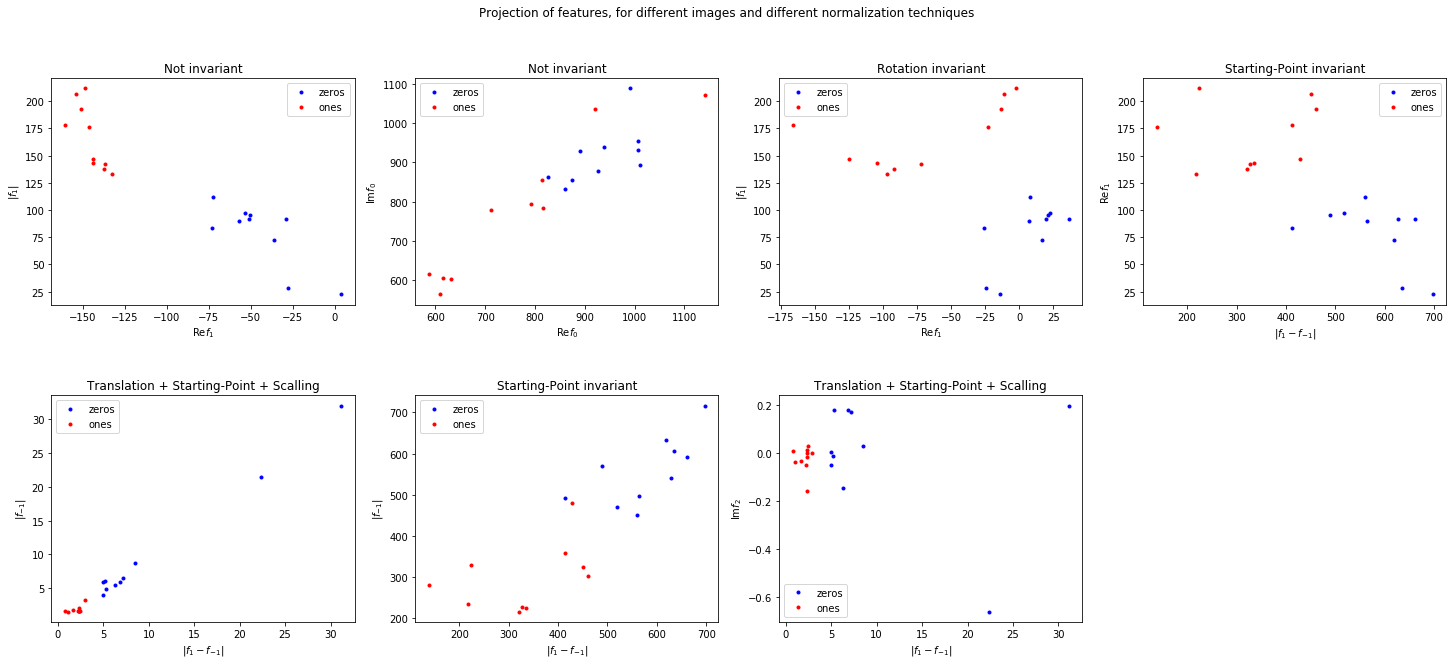

In [7]:
# 1. Construction of the experiment (make the data-model to generate plot easily)
plots_to_make = [] 
plots_to_make.append(PlotData("Not invariant", [0,0,0,0], [0,1]))
plots_to_make.append(PlotData("Not invariant", [0,0,0,0], [5,6]))
plots_to_make.append(PlotData("Rotation invariant", [1,0,0,0], [0, 1]))
plots_to_make.append(PlotData("Starting-Point invariant", [0,0,0,1], [3, 0]))
plots_to_make.append(PlotData("Translation + Starting-Point + Scalling", [0,1,1,1], [3, 2]))
plots_to_make.append(PlotData("Starting-Point invariant", [0,0,0,1], [3, 2]))
plots_to_make.append(PlotData("Translation + Starting-Point + Scalling", [0,1,1,1], [3, 4]))

# 2. Make some nice plots illustrating all this
fig, axs = plt.subplots(2,4,figsize = (25,10))
axs = axs.ravel()
for i, plotData in enumerate(plots_to_make):
    x_zeros, x_ones = [], []
    ax = axs[i]
    for img in zeros: x_zeros.append(imPro.get_feature_vector(img, plotData.invariances))
    for img in ones: x_ones.append(imPro.get_feature_vector(img, plotData.invariances))
    x_zeros, x_ones = np.array(x_zeros), np.array(x_ones)
    ax.plot(x_zeros[:,plotData.features[0]], x_zeros[:,plotData.features[1]],'.b', label = 'zeros')
    ax.plot(x_ones[:,plotData.features[0]], x_ones[:,plotData.features[1]],'.r', label = 'ones')
    labels = plotData.get_features_label()
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title(plotData.name)
    ax.legend()
fig.subplots_adjust(hspace=0.4)
fig.delaxes(axs[-1])
fig.suptitle("Projection of features, for different images and different normalization techniques");

#### Discussion of Fourier Descriptor Results
todo arthur

## 1.3 Region based Methods
We tested several region based descriptors : area and area in the polygon connecting the contour points, perimeter
wich are shift and rotation invariant but still scale variant. We can integrate them in the compacity descriptor, which becomes scale invariant. We also tested projection (which is variant in translation, rotation and scaling) and moments, invariant in translation, and moments, which can be tuned to standard centered moments and become invariant to rotation, shift and scaling.

In [14]:
##here without moments (commented in lab02_functions)
param_zeros=imPro.region_based_features(zeros)
param_ones=imPro.region_based_features(ones)

<Figure size 432x288 with 0 Axes>

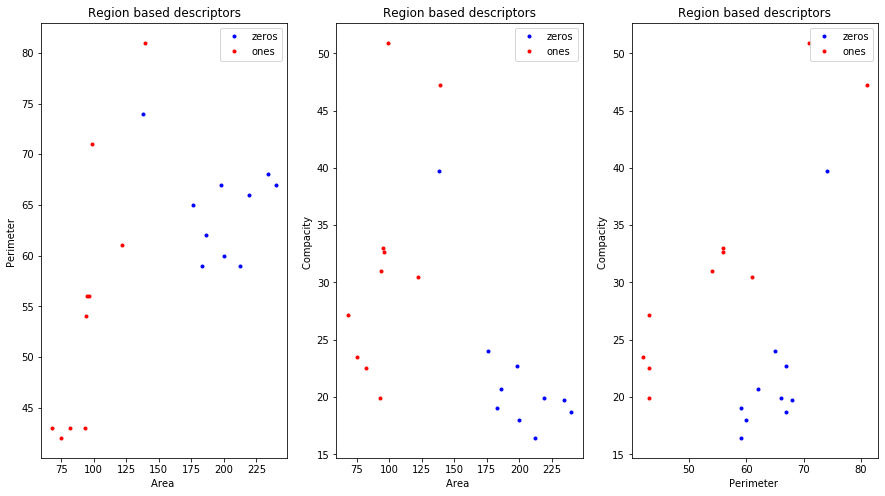

In [13]:
plt.figure()
fig, axs = plt.subplots(1,3, figsize = (15,8))

axs[0].plot(param_zeros[:,0], param_zeros[:,1],'.b', label = 'zeros')
axs[0].plot(param_ones[:,0], param_ones[:,1],'.r', label = 'ones')
axs[0].set_xlabel('Area ')
axs[0].set_ylabel('Perimeter ')
axs[0].set_title('Region based descriptors')
axs[0].legend()

axs[1].plot(param_zeros[:,0], param_zeros[:,2],'.b', label = 'zeros')
axs[1].plot(param_ones[:,0], param_ones[:,2],'.r', label = 'ones')
axs[1].set_xlabel('Area ')
axs[1].set_ylabel('Compacity ')
axs[1].set_title('Region based descriptors')
axs[1].legend()

axs[2].plot(param_zeros[:,1], param_zeros[:,2],'.b', label = 'zeros')
axs[2].plot(param_ones[:,1], param_ones[:,2],'.r', label = 'ones')
axs[2].set_xlabel('Perimeter ')
axs[2].set_ylabel('Compacity ')
axs[2].set_title('Region based descriptors')
axs[2].legend()

#axs[3].plot(param_zeros[:,2], param_zeros[:,4],'.b', label = 'zeros')
#axs[3].plot(param_ones[:,2], param_ones[:,4],'.r', label = 'ones')
#axs[3].set_xlabel('Compacity ')
#axs[3].set_ylabel('Standard centered moment ')
#axs[3].set_title('Region based descriptors')
#axs[3].legend()

plt.show()

Comments on the plots

## 1.4 Other Methods
The method presented here is similar to a contour based but relies instead on the morphological skeleton of the image. This so called skeleton is built using morphological operations like erosions and dilations. Once a skeleton has been extracted the same or similar approaches like for contour and/or region based feature detection can be applied. In this section two examples are testes, showing a good choice and a bad choice for skeleton features and how other features could be described.

The first steps are therefore the skeletonization of the images. The results are shown below for the two series of handwritten glyphs:

In [ ]:
#load image stacks
path_to_img_data='lab-02-data/part1/'
img_zeros=imPro.load_img_seq(os.path.join(path_to_img_data, '0'))
img_ones=imPro.load_img_seq(os.path.join(path_to_img_data, '1'))

#skeletonize stacks
skel_zeros=imPro.skel_img_stack(img_zeros)
skel_ones=imPro.skel_img_stack(img_ones)

#plot skeletons of glyphs
fig, axes = plt.subplots(2, len(skel_ones), figsize=(12, 3))
for ax, im in zip(axes[0], skel_zeros):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
for ax, im in zip(axes[1], skel_ones):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

### Feature Extraction from Skeletons
When working with classification algorithms an important part for the proper classification is the choice of good features. This is always true and here is an example of a bad choice: a pair of features could be the two inertias along the principal axes of the object. However, knowing that some _ones_ are more than just a line and have a given width which is comparable with that of the _zeros_, one may expect this features to fail when comparing the two classes. The same is true for the very slim zeros which may be confused with ones due to their small "lateral inertia".

The inertias are deduced from the covariance matrix of the objects, which is build from the pixels coordinates, the pixel values and its center of mass. Once this matrix is computed the eigenvalues are extracted, which is equivalent to analysing the inertia along the principal axis of the object. This is done as follows:

In [ ]:
u10=[]
u20=[]
u11=[]
u21=[]

for i in range(len(skel_zeros)):
    # find eigenvalues (inertia) of zeros along principal axis
    Lambda,_=np.linalg.eig(imPro.object_covar_mat(skel_zeros[i]))
    u10.append(Lambda[0])
    u20.append(Lambda[1])

    #do the same for ones
    Lambda,_=np.linalg.eig(imPro.object_covar_mat(skel_ones[i]))
    u11.append(Lambda[0])
    u21.append(Lambda[1])

## Additional features:
The second pair of features that we are going to analyze are the relative distances between the handwritten glyph and a reference one. This is a good feature for binary classification of the type "it is part of this class" or "it is not part of this class", if low dimentionality of the feature space is important. This can be understood with an example of classification where we want to classify several characters like 1,2,3 and 4. In this case to properly separate them and classify them, one would would need more than just two distances, which forces the classification algorithms in higher dimentions if no reduction of dimentionality is applied. Otherwise, one could only say with two features something like: "the glyph is a 1" or "the glyph is not a 1". This again could be overcome by doing a chained classification so that if "it is not a 1" the the same approach is made testing for another glyph, until a test is positive.

Since the disticntion we here seek to accomplish is only between two glyphs, this approach is valid and can easily be implemented in a 2D featurespace. Therefore, the first step is to generate reference glyphs, skeletonize them and build a distance map:


In [ ]:
#read and plot reference images
ref_path='lab-02-data/ref/'
ref_zero=skimage.io.imread(os.path.join(ref_path,'reference0.png'))
ref_one=skimage.io.imread(os.path.join(ref_path,'reference1.png'))

#plot reference images
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0][0].imshow(ref_zero)
ax[0][1].imshow(ref_one)
ax[0][0].set_title('Reference zero')
ax[0][0].axis('off')
ax[0][1].set_title('Reference one')
ax[0][1].axis('off')

#skeletonize and plot ref images
ref_zero=imPro.skel_and_thld(ref_zero)
ref_one=imPro.skel_and_thld(ref_one)

#create and plot distance map
zero_dist_map=imPro.dist_map(ref_zero.astype(int))
one_dist_map=imPro.dist_map(ref_one.astype(int))

#plot reference skeletons
ax[1][0].imshow(ref_zero)
ax[1][1].imshow(ref_one)
ax[1][0].set_title('Reference skeleton zero')
ax[1][0].axis('off')
ax[1][1].set_title('Reference skeleton one')
ax[1][1].axis('off')


#plot distance map
ax[2][0].imshow(zero_dist_map)
ax[2][1].imshow(one_dist_map)
ax[2][0].set_title('Distance map zero')
ax[2][0].axis('off')
ax[2][1].set_title('Distance map one')
ax[2][1].axis('off')


## Comparison:
now that the maps have been created it is time to compare the mean distances, considered as features here: Note that dx0 is average ditance of object _x_ to the _zeros_ and dx1 is defined accordingly for the _ones_ in the next section of code

In [ ]:
d11=[]
d10=[]

for img in skel_ones:
    #center objects:
    x_com,y_com=imPro.com(img)
    img=np.roll(img,(int(x_com),int(y_com)))
    #compute total number of pixels of object
    N=np.sum(img)
    #compute average distance
    d10.append(np.sum(zero_dist_map[img])/N)
    d11.append(np.sum(one_dist_map[img])/N)

d01=[]
d00=[]

for img in skel_zeros:
    #center objects:
    x_com,y_com=imPro.com(img)
    img=np.roll(img,(int(x_com),int(y_com)))
    #compute total number of pixels of object
    N=np.sum(img)
    #compute average distance
    d00.append(np.sum(zero_dist_map[img])/N)
    d01.append(np.sum(one_dist_map[img])/N)


## Analysis of the First Pair of Features:
As expected, the classes are not completly separable and overlap as we can see in the plot below. This means that those are not good features to separate this two objects one from the other. Indeed, the two _ones_ which are a bit larger are confused with _zeros_ wich are a bit slimmer. Nonetheless, we can see from this that this approach would probably work just fine if the _ones_ where all simple lines. Indeed, the _ones_ which are a line present the second inertia to be negligible compared to that of a _zero_. Pruning the skeleton could probably further improve the separation between the two classes. It can be interesting to note that the computation of the inertia is invariant to rotation as it extract the object's principal axes.

## Analysis of the Second Pair of Features:
The result of this feature analysis shows that those features could be used to linearly separate the two glyphs one fro the other. Indeed, as one would expect, the _zeros_ show greater distance to the reference _one_ and a smaller deistance to the reference _zero_, and the same reasoning applies for the _ones_ which show greater proximity to the reference _one_ rather than the reference _zero_. The result is shown below. From this we can conclude that it is important to carefully choose the features if a good separation needs to be achived. Indeed in the example above the inertia of the object alone does not suffice to classify the different objects without mistakes, wherease this approach of realtive distances is more promising in this case.


In the plot below the object's principal axes are denoted with u1 and u2:


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
ax[0].plot(u10,u20,'.b',label='zeros')
ax[0].plot(u11,u21,'.r',label='ones')
ax[0].set_title("Inertia along principal axes of object")
ax[0].set_xlabel("u1")
ax[0].set_ylabel("u2")
ax[0].legend()

ax[1].plot(d00,d01,'.b',label='zeros')
ax[1].plot(d10,d11,'.r',label='ones')
ax[1].set_xlabel('Distance from object to reference "0"')
ax[1].set_ylabel('Distance from object to reference "1"')
ax[1].set_title("Distance to reference glyphs")
ax[1].legend()

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

In [ ]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here